# Evaluation

We run inference with a few different models to evaluate whether reinforcement fine-tuning (RFT) through GRPO improves
performance on causal gene identification.

* Zero-shot Llama 3.1-8B Instruct
* GRPO-tuned Llama 3.1-8B Instruct
* Zero-shot Llama 3.1-70B Instruct

In [435]:
import pandas as pd
import numpy as np

def compute_bootstrap_se(values):
    bootstrap_means = [np.mean(np.random.choice(values,size=len(values),replace=True)) for _ in range(10000)]
    se = np.std(bootstrap_means,ddof=1)
    return se 

def extract_metrics(df,top_k=1):
    df['predicted_genes'] = df['genes'].apply(lambda x:str(x).replace("[","").replace("]","").replace(" ","").split(","))
    df['top_1_correct'] = df.apply(lambda x: x['true_answer'] in x['predicted_genes'][:top_k],axis=1)
    # Accuracy
    top_1_acc = df.top_1_correct.mean()
    # Compute bootstrapped se
    top_1_se = compute_bootstrap_se(df.top_1_correct.values)
    # Additional metric of bad formatting in answer
    bad_format_rate = df.raw_response.apply(lambda x: '<genes>' not in x).mean()
    return top_1_acc,top_1_se,bad_format_rate

In [ ]:
models = ['zero_shot_8b','grpo_8b','zero_shot_70b']
result_list = []
for model in models:
    fname = f"results/{model}_results.csv"
    df = pd.read_csv(fname)
    top_1_acc,top_1_se,bad_format_rate = extract_metrics(df)
    result_list.append([model,top_1_acc,top_1_se,bad_format_rate])
result_df = pd.DataFrame(result_list,columns=['model','top_1_accuracy','top_1_se','format_err']) 

In [421]:
import matplotlib.pyplot as plt

def plot_result(result_df,save_file,acc_type='top_1',xlabels=None):
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.bar(result_df["model"], result_df[f"{acc_type}_accuracy"], yerr=1.37*result_df[f"{acc_type}_se"], 
            capsize=5, color=plt.cm.tab10(range(len(result_df))))
    if xlabels:
        plt.xticks(range(len(xlabels)), labels=xlabels)
    plt.xlabel("Model")
    plt.ylabel(f"{acc_type.capitalize().replace("_","-")} Accuracy")
    plt.ylim(0, 1)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(save_file)
    plt.show()

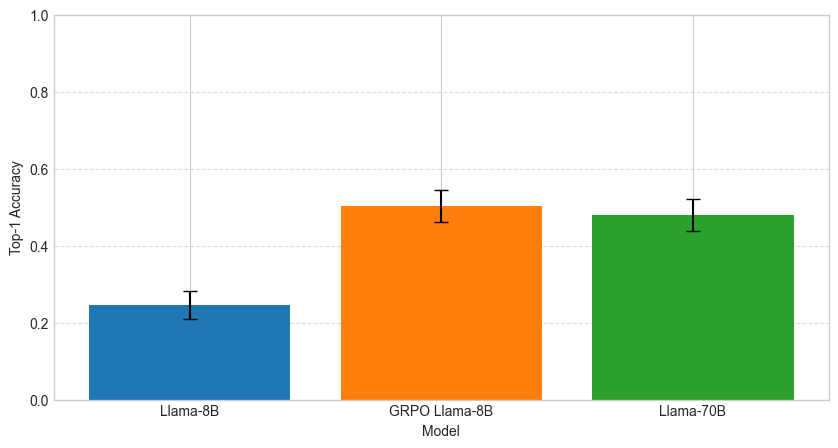

In [ ]:
plot_result(result_df,'figures/main_comparison.png',xlabels=['Llama-8B','GRPO Llama-8B','Llama-70B'])

In [423]:
print(result_df)

           model  top_1_accuracy  top_1_se  format_err
0   zero_shot_8b        0.245421  0.026020    0.395604
1        grpo_8b        0.501832  0.030516    0.003663
2  zero_shot_70b        0.479853  0.029907    0.010989


# Binary rewards vs ranked rewards

Most RFT demonstrations use binary rewards for correct/incorrect answers, with no partial rewards. The OpenAI demo included a "inverse rank" reward function that provided partial rewards depending on the location of the "correct" gene in the ranked list generated by the LLM. Our implementation uses the same format for our reward function.

What if we instead used a binary reward function with no partial credit for our problem? Does this reduce performance? To test this, I created a new reward function with reward 1 if the correct gene was at rank 1, else reward 0. 

With only this change, the model was retrained for the same number of epochs as the original GRPO run.

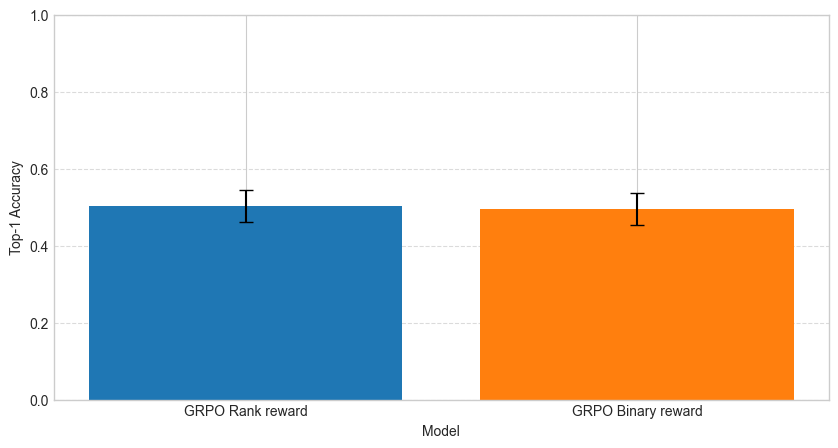

In [ ]:
models = ['grpo_8b','grpo_8b_binary_reward']
result_list = []
for model in models:
    fname = f"results/{model}_results.csv"
    df = pd.read_csv(fname)
    acc, se, err = extract_metrics(df)
    result_list.append([model,acc,se, err])
result_df = pd.DataFrame(result_list,columns=['model','top_1_accuracy','top_1_se','format_err']) 
plot_result(result_df,'figures/reward_type_comparison.png',xlabels=['GRPO Rank reward','GRPO Binary reward'])


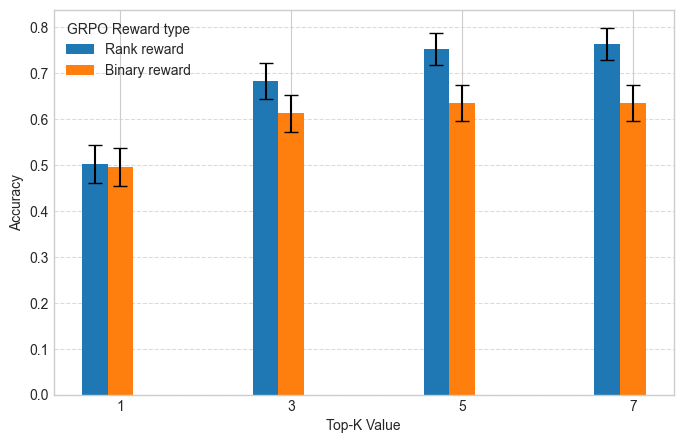

In [ ]:
models = ['grpo_8b','grpo_8b_binary_reward']
labels = ['Rank reward','Binary reward']
top_k_vals = [1,3,5,7]
result_list = []
for model in models:
    fname = f"results/{model}_results.csv"
    df = pd.read_csv(fname)
    for k in top_k_vals:
        acc, se, err = extract_metrics(df,top_k=k)
        result_list.append([model,acc,se,err,k])
result_df = pd.DataFrame(result_list,columns=['model','accuracy','se','format_err','top_k_value']) 

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.3 

for i, model in enumerate(models):
    subset = result_df[result_df["model"] == model]
    x_positions = subset["top_k_value"] + (i - len(models) / 2) * bar_width  # Offset bars
    ax.bar(x_positions, subset["accuracy"], yerr=1.37*subset["se"], capsize=5, width=bar_width, label=labels[i])

# Customizing plot
ax.set_xlabel("Top-K Value")
ax.set_ylabel("Accuracy")
ax.set_xticks(top_k_vals)  # Ensure proper tick positions
ax.set_xticklabels(top_k_vals)  # Labeling x-axis
ax.legend(title="GRPO Reward type")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('figures/reward_type_comparison_multi_k.png')
# Show plot
plt.show()


In [427]:
result_df

,model,top_1_accuracy,top_1_se,format_err
0,grpo_8b,0.501832,0.030229,0.003663
1,grpo_8b_binary_reward,0.494505,0.029863,0.025641


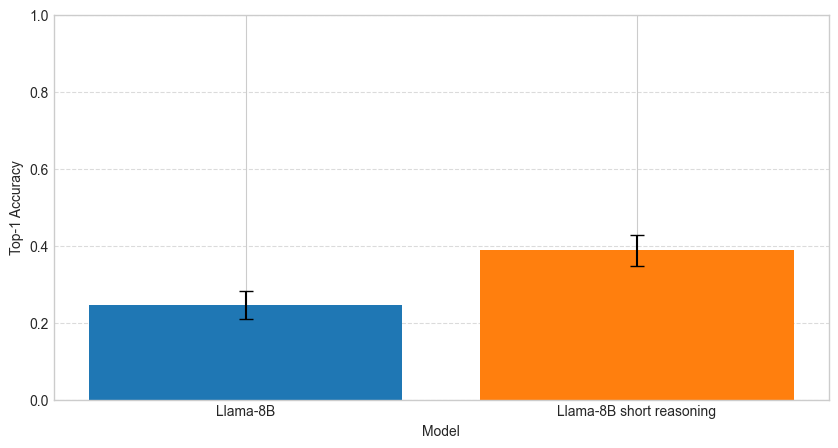

In [ ]:
models = ['zero_shot_8b','zero_shot_8b_short_prompt']
result_list = []
for model in models:
    fname = f"results/{model}_results.csv"
    df = pd.read_csv(fname)
    acc, se, err = extract_metrics(df)
    result_list.append([model,acc,se, err])
result_df = pd.DataFrame(result_list,columns=['model','top_1_accuracy','top_1_se','format_err']) 
print(result_df)